In [3]:
import os
import json
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import requests
import io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [ ]:
class SolarDataset(Dataset):
    def __init__(self, root_dir):
        """
        Args:
            root_dir (string): Directory containing the 4 subfolders.
        """
        self.root_dir = root_dir
        
        self.meta_dir = os.path.join(root_dir, "Metadata")
        self.rgb_dir = os.path.join(root_dir, "RGB Flat")
        self.height_dir = os.path.join(root_dir, "Height")
        self.shadow_dir = os.path.join(root_dir, "Shadow")
        
        self.meta_files = sorted([f for f in os.listdir(self.meta_dir) if f.startswith("meta_") and f.endswith(".json")])
        
    def __len__(self):
        return len(self.meta_files)

    def __getitem__(self, idx):
        # 1. Identify the file ID
        meta_filename = self.meta_files[idx]
        file_id = meta_filename.split("_")[1].split(".")[0] # e.g., "0001"
        
        # 2. Load the Metadata from the Metadata Folder
        meta_path = os.path.join(self.meta_dir, meta_filename)
        with open(meta_path, 'r') as f:
            meta_data = json.load(f)
        
        sun_vector = torch.tensor(meta_data["sun_vector"], dtype=torch.float32)
        
        # 3. Load Images from their specific folders
        # Note: Your filenames are like "rgb_0000.png", so we construct that path
        # rgb_path = os.path.join(self.rgb_dir, f"rgb_{file_id}.png")
        rgb_path = os.path.join(self.rgb_dir, f"rgb_flat_{file_id}.png")
        height_path = os.path.join(self.height_dir, f"height_{file_id}.png")
        shadow_path = os.path.join(self.shadow_dir, f"shadow_{file_id}.png")
        
        # Open images
        rgb_img = Image.open(rgb_path).convert("RGB")
        height_img = Image.open(height_path).convert("L") 
        shadow_img = Image.open(shadow_path).convert("L")

        color_transform = transforms.ColorJitter(
            brightness=0.4, # +/- 40%
            contrast=0.4,   # +/- 40%
            saturation=0.4, # +/- 40%
            hue=0.1         # Slight color shift
        )
        rgb_img = color_transform(rgb_img)
        
        # 4. Transform to Tensors
        to_tensor = transforms.ToTensor()
        
        return {
            "rgb": to_tensor(rgb_img),
            "height": to_tensor(height_img),
            "shadow": to_tensor(shadow_img),
            "sun_vector": sun_vector,
            "id": file_id
        }

In [10]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [11]:
class SelfAttentionBlock(nn.Module):
    """
    Standard Vision Transformer Self-Attention Block for the Bottleneck
    """
    def __init__(self, in_channels):
        super().__init__()
        self.norm = nn.GroupNorm(8, in_channels)
        self.query = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key   = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch, C, H, W = x.size()
        
        # 1. Project
        q = self.query(x).view(batch, -1, H * W).permute(0, 2, 1) # B, N, C'
        k = self.key(x).view(batch, -1, H * W)                    # B, C', N
        v = self.value(x).view(batch, -1, H * W)                  # B, C, N
        
        # 2. Attention Map
        attn = torch.bmm(q, k) # B, N, N
        attn = F.softmax(attn, dim=-1)
        
        # 3. Apply
        out = torch.bmm(v, attn.permute(0, 2, 1)) # B, C, N
        out = out.view(batch, C, H, W)
        
        # 4. Residual Connection + Scale
        return x + self.gamma * out

In [ ]:
class SolarFold_Attention(nn.Module):
    def __init__(self, n_channels=3, n_classes=1):
        super().__init__()
        
        # Input: RGB (3) + Prev_Height (1) = 4
        input_dim = 4
        
        self.inc = DoubleConv(input_dim, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))
        
        # --- THE ALPHAFOLD INSPIRED PART ---
        # A bridge that understands global geometry
        self.bottleneck_attn = SelfAttentionBlock(512)
        # -----------------------------------
        
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(512, 256)
        
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(256, 128)
        
        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(128, 64)
        
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)
        self.sigmoid = nn.Sigmoid() 

    def forward(self, x, sun_vector=None, prev_height=None, n_cycles=3):
        # P.s: sun_vector is accepted in args to keep training loop clean, 
        # but NOT used in the U-Net. This forces intrinsic learning.
        
        batch_size, _, h, w = x.shape
        
        if prev_height is None:
            prev_height = torch.zeros(batch_size, 1, h, w).to(x.device)
            
        final_output = prev_height
        
        # Keep original X safe
        input_image = x 
        
        for i in range(n_cycles):
            # NO SUN VECTOR HERE. Just Image + Geometry.
            combined_input = torch.cat([input_image, final_output], dim=1)
            
            x1 = self.inc(combined_input)
            x2 = self.down1(x1)
            x3 = self.down2(x2)
            x4 = self.down3(x3)
            
            # Apply Attention at the deepest level
            x4 = self.bottleneck_attn(x4)
            
            d = self.up1(x4)
            d = torch.cat([d, x3], dim=1)
            d = self.conv1(d)
            
            d = self.up2(d)
            d = torch.cat([d, x2], dim=1)
            d = self.conv2(d)
            
            d = self.up3(d)
            d = torch.cat([d, x1], dim=1)
            d = self.conv3(d)
            
            logits = self.outc(d)
            final_output = self.sigmoid(logits)
            
        return final_output

In [ ]:
class VectorizedRayCaster(nn.Module):
    def __init__(self, max_height=8.0, ortho_scale=20.0, res=256):
        super().__init__()
        self.max_height = max_height
        self.meters_per_pixel = ortho_scale / res 

    def forward(self, height_map, sun_vector, steps=64):
        """
        Vectorized Shadow Casting.
        height_map: [B, 1, H, W]
        sun_vector: [B, 3]
        """
        B, _, H, W = height_map.shape
        device = height_map.device
        
        # 1. Precompute Directions for the whole Batch
        # sun_vector is [B, 3] -> dx, dy, slope need to be [B, 1, 1, 1]
        dx_val = -sun_vector[:, 0]
        dy_val = -sun_vector[:, 1]
        ground_dist = torch.sqrt(sun_vector[:, 0]**2 + sun_vector[:, 1]**2) + 1e-6
        slope_val = sun_vector[:, 2] / ground_dist
        
        # Expand for broadcasting
        dx_val = dx_val.view(B, 1, 1, 1)
        dy_val = dy_val.view(B, 1, 1, 1)
        slope_val = slope_val.view(B, 1, 1, 1)
        
        real_height = height_map * self.max_height
        current_max_shadow = torch.zeros_like(real_height)
        
        # 2. Ray Marching (Vectorized Step)
        for i in range(1, steps):
            dist_meters = i * self.meters_per_pixel
            
            # Create a translation grid
            theta = torch.eye(2, 3, device=device).unsqueeze(0).repeat(B, 1, 1) # [B, 2, 3]
            
            shift_x = (dx_val * i) * (2.0 / W)
            shift_y = (dy_val * i) * (2.0 / H)
            
            # Apply shift to translation part of affine matrix
            # Grid sample uses (x, y) coordinates. 
            # To move image "Down/Right", we actually look "Up/Left", so signs might flip depending on implementation
            theta[:, 0, 2] = -shift_x.squeeze()
            theta[:, 1, 2] = -shift_y.squeeze()
            
            grid = F.affine_grid(theta, real_height.size(), align_corners=False)
            blocker = F.grid_sample(real_height, grid, align_corners=False, padding_mode="border")
            
            # Calculate height loss
            height_loss = dist_meters * slope_val
            
            diff = (blocker - height_loss) - real_height
            current_max_shadow = torch.maximum(current_max_shadow, diff)

        final_shadow = torch.sigmoid(current_max_shadow * 50)
        return final_shadow

In [14]:
class GaussianSmoothing(nn.Module):
    """
    Apply gaussian smoothing on a 1d, 2d or 3d tensor. Filtering is performed seperately for each channel
    in the input using a depthwise convolution.
    """
    def __init__(self, channels, kernel_size=3, sigma=0.5):
        super(GaussianSmoothing, self).__init__()
        
        # 1. Create 1D Gaussian
        lim = (kernel_size - 1) / 2.
        x = torch.linspace(-lim, lim, kernel_size)
        gauss_1d = torch.exp(-x**2 / (2 * sigma**2))
        
        # 2. Create 2D Gaussian (Outer Product)
        # Multiplies vertical vector by horizontal vector to get a square grid
        gauss_2d = torch.ger(gauss_1d, gauss_1d)
        gauss_2d = gauss_2d / gauss_2d.sum() # Normalize
        
        # 3. Reshape [Channels, 1, K, K] for depthwise conv
        kernel = gauss_2d.view(1, 1, kernel_size, kernel_size)
        kernel = kernel.repeat(channels, 1, 1, 1)
        
        self.register_buffer('weight', kernel)
        self.groups = channels
        self.padding = kernel_size // 2  # e.g., if K=3, pad=1. If K=5, pad=2.

    def forward(self, x):
        return F.conv2d(x, self.weight, groups=self.groups, padding=self.padding)

In [ ]:
# ==========================================
# CONFIGURATION
# ==========================================
BATCH_SIZE = 10 # 8          # Lower this if you run out of GPU Memory
LEARNING_RATE = 5e-4 # 1e-4
NUM_EPOCHS = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset_path = "/kaggle/input/solarfold-v4/SolarFold_V4" 

Dataset Loaded! Found 1060 examples.

Sample Data Shapes:
RGB: torch.Size([3, 256, 256])
Height: torch.Size([1, 256, 256])
Shadow: torch.Size([1, 256, 256])
Sun Vector: tensor([-0.2340, -0.3683,  0.8998])


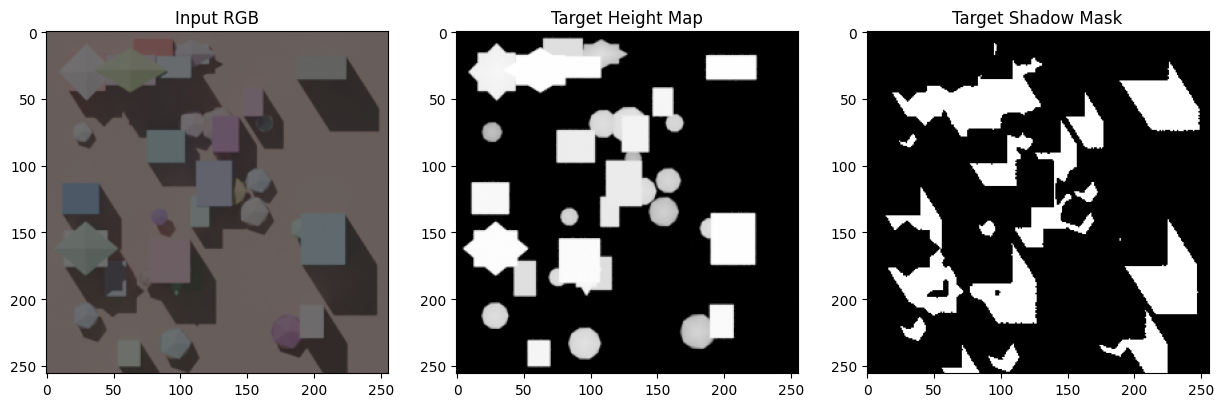

In [ ]:
# Create the dataset
try:
    dataset = SolarDataset(dataset_path)
    print(f"Dataset Loaded! Found {len(dataset)} examples.")

    sample = dataset[0]
    print("\nSample Data Shapes:")
    print(f"RGB: {sample['rgb'].shape}")         # Should be [3, 256, 256]
    print(f"Height: {sample['height'].shape}")   # Should be [1, 256, 256]
    print(f"Shadow: {sample['shadow'].shape}")   # Should be [1, 256, 256]
    print(f"Sun Vector: {sample['sun_vector']}") # Should be tensor([x, y, z])

    # Show the images
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(sample['rgb'].permute(1, 2, 0)) # Permute needed for plotting
    ax[0].set_title("Input RGB")
    
    ax[1].imshow(sample['height'].squeeze(), cmap='gray')
    ax[1].set_title("Target Height Map")
    
    ax[2].imshow(sample['shadow'].squeeze(), cmap='gray')
    ax[2].set_title("Target Shadow Mask")
    plt.show()

except Exception as e:
    print(f"Could not load dataset. Check path! Error: {e}")

In [ ]:
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

model = SolarFold_Attention().to(device)
physics = VectorizedRayCaster().to(device)
smoother = GaussianSmoothing(channels=1, kernel_size=3, sigma=0.5).to(device)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

criterion_height = nn.L1Loss()
criterion_shadow = nn.BCELoss()      # For Shadow Mask (Binary Classification)

In [ ]:
print(f"Starting Training on {device}...")
loss_history = []

for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    
    for i, batch in enumerate(train_loader):
        img = batch['rgb'].to(device)
        target_height = batch['height'].to(device)
        target_shadow = batch['shadow'].to(device)
        sun_vector = batch['sun_vector'].to(device)
        
        # Zero Gradients
        optimizer.zero_grad()

        # FORWARD PASS
        # 1. Leo (our architect) guesses the height (Recycles 3 times)
        pred_height = model(img, sun_vector, n_cycles=3)

        # SMOOTH IT
        # This kills the noise before the physics engine sees it.
        # We use this smoothed version for shadow calculation AND loss calculation
        pred_height_smooth = smoother(pred_height)
        
        # 2. Physics Engine calculates the shadow
        # pred_shadow = physics(pred_height, sun_vector)
        pred_shadow = physics(pred_height_smooth, sun_vector)
        
        # Loss 1: Did you guess the height right?
        loss_h = criterion_height(pred_height_smooth, target_height) * 20.0
        
        # Loss 2: Did the physics match?
        # We add a small epsilon to avoid log(0) errors in BCE
        # SAFETY FIX: Clamp the predictions to be strictly inside (0, 1) range
        # We clamp between 0.0001 and 0.9999
        safe_shadow = torch.clamp(pred_shadow, min=1e-4, max=1.0-1e-4)
        loss_s = criterion_shadow(safe_shadow, target_shadow) * 1.0 # the 1.0 multiplier is left, so you can increase/decrease it as you like
        
        # Total Loss (You can weigh these differently if you want!)
        total_loss = loss_h + loss_s
        
        # BACKWARD PASS
        total_loss.backward()
        optimizer.step()
        
        running_loss += total_loss.item()
        
        # Print status every 50 batches
        if i % 50 == 0:
            # Check the max height value Leo is predicting for sanity check
            max_h = pred_height_smooth.max().item()
            print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Step [{i}/{len(train_loader)}], Loss: {total_loss.item():.4f}, Max Predicted Height: {max_h:.4f}")
            print(f"  Height Loss (L1): {loss_h.item():.5f}")
            print(f"  Shadow Loss (BCE): {loss_s.item():.5f}")
            
    if (epoch + 1) % 2 == 0:
        torch.save(model.state_dict(), f'/kaggle/working/solarfold_v1_epoch_{epoch+1}.pth')
        print(f"Model saved at epoch {epoch+1}")

    epoch_loss = running_loss / len(train_loader)
    loss_history.append(epoch_loss)
    print(f"--> END EPOCH {epoch+1} | Avg Loss: {epoch_loss:.4f}")

print("Training Complete!")

Starting Training on cuda...
Epoch [1/20], Step [0/106], Loss: 9.9844, Max Predicted Height: 0.7276
  Height Loss (L1): 7.90498
  Shadow Loss (BCE): 2.07942
Epoch [1/20], Step [50/106], Loss: 6.0433, Max Predicted Height: 0.8972
  Height Loss (L1): 5.22498
  Shadow Loss (BCE): 0.81828
Epoch [1/20], Step [100/106], Loss: 5.6890, Max Predicted Height: 0.8709
  Height Loss (L1): 4.71655
  Shadow Loss (BCE): 0.97248
--> END EPOCH 1 | Avg Loss: 6.3713
Epoch [2/20], Step [0/106], Loss: 5.1196, Max Predicted Height: 0.8495
  Height Loss (L1): 4.26720
  Shadow Loss (BCE): 0.85240
Epoch [2/20], Step [50/106], Loss: 4.3913, Max Predicted Height: 0.8481
  Height Loss (L1): 3.35599
  Shadow Loss (BCE): 1.03527
Epoch [2/20], Step [100/106], Loss: 3.0763, Max Predicted Height: 0.9163
  Height Loss (L1): 2.04704
  Shadow Loss (BCE): 1.02926
Model saved at epoch 2
--> END EPOCH 2 | Avg Loss: 4.3790
Epoch [3/20], Step [0/106], Loss: 2.9888, Max Predicted Height: 0.8857
  Height Loss (L1): 1.94195
  Sha

In [12]:
torch.save(model.state_dict(), '/kaggle/working/solarfold_v5.pth')
print("Model saved successfully!")

Model saved successfully!


In [2]:
!ls '/kaggle/working'

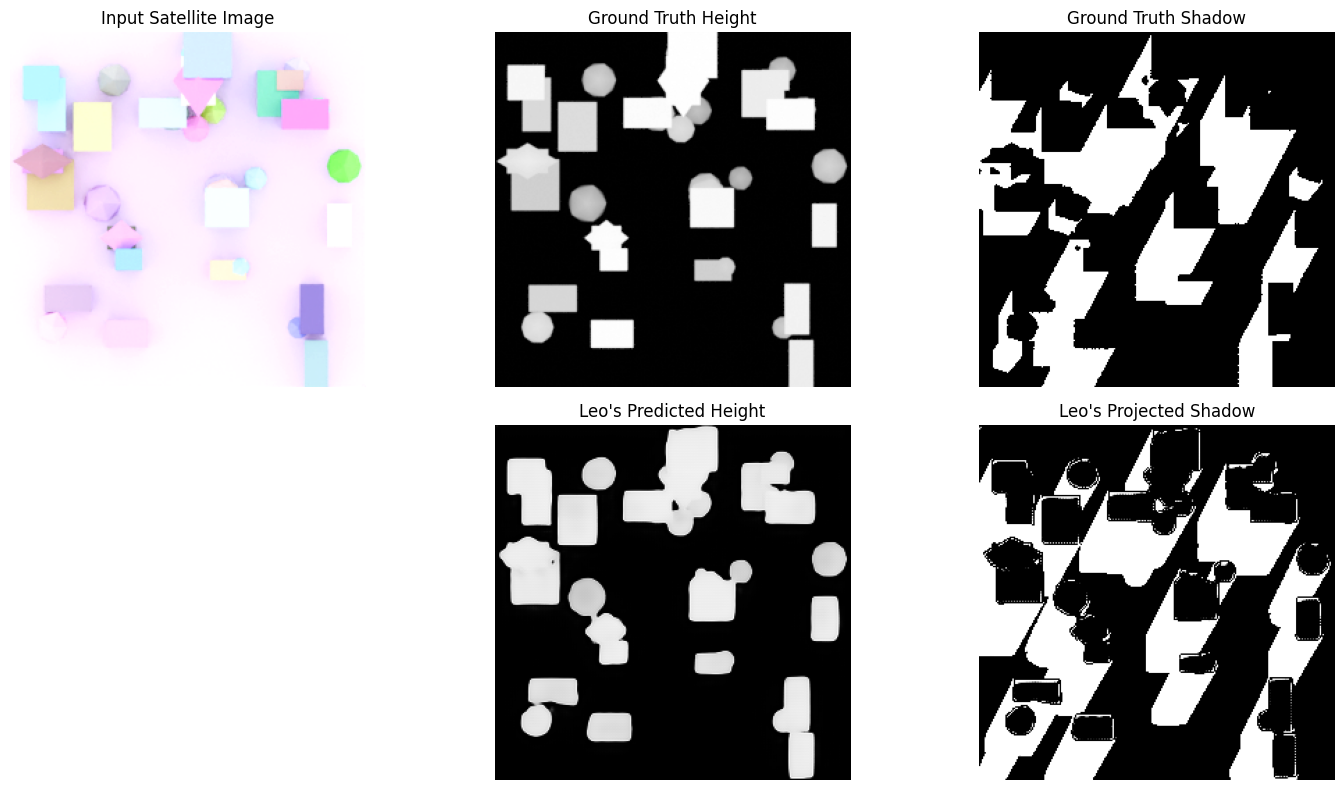

In [ ]:
# Visualize
model.eval() # Set to evaluation mode

data_iter = iter(train_loader)
batch = next(data_iter)

img = batch['rgb'].to(device)
sun = batch['sun_vector'].to(device)
target_h = batch['height'].to(device)
target_s = batch['shadow'].to(device)

with torch.no_grad():
    pred_h = model(img, sun, n_cycles=3)
    pred_s = physics(pred_h, sun)

# Plot the first image in the batch
idx = 0

plt.figure(figsize=(15, 8))

# 1. Input Image
plt.subplot(2, 3, 1)
plt.imshow(img[idx].permute(1, 2, 0).cpu())
plt.title("Input Satellite Image")
plt.axis('off')

# 2. Ground Truth Height
plt.subplot(2, 3, 2)
plt.imshow(target_h[idx].squeeze().cpu(), cmap='gray')
plt.title("Ground Truth Height")
plt.axis('off')

# 3. Ground Truth Shadow
plt.subplot(2, 3, 3)
plt.imshow(target_s[idx].squeeze().cpu(), cmap='gray')
plt.title("Ground Truth Shadow")
plt.axis('off')

# 4. PREDICTED Height
plt.subplot(2, 3, 5)
plt.imshow(pred_h[idx].squeeze().cpu(), cmap='gray')
plt.title("Leo's Predicted Height")
plt.axis('off')

# 5. PREDICTED Shadow
plt.subplot(2, 3, 6)
plt.imshow(pred_s[idx].squeeze().cpu(), cmap='gray')
plt.title("Leo's Projected Shadow")
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def predict_shadow(image_path, sun_azimuth, sun_elevation, model_path='/kaggle/working/solarfold_v5.pth'):
    """
    Takes an image path and sun angles, returns the predicted 3D Height and Shadow.
    """
    # 1. Setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = SolarFold_Attention().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval() # Freeze weights
    physics = VectorizedRayCaster().to(device)
    
    # 2. Process Image
    img_pil = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((256, 256)), # Ensure size matches training
        transforms.ToTensor()
    ])
    img_tensor = transform(img_pil).unsqueeze(0).to(device) # Add batch dim [1, 3, 256, 256]
    
    # 3. Process Sun Vector
    # Convert Azimuth/Elevation (Degrees) -> Vector (X, Y, Z)
    az_rad = np.radians(sun_azimuth)
    el_rad = np.radians(sun_elevation)
    
    sun_x = np.cos(el_rad) * np.sin(az_rad)
    sun_y = np.cos(el_rad) * np.cos(az_rad)
    sun_z = np.sin(el_rad)
    
    sun_tensor = torch.tensor([sun_x, sun_y, sun_z], dtype=torch.float32).unsqueeze(0).to(device)
    
    # 4. RUN LEO
    with torch.no_grad():
        # Predict Height (The Clay)
        pred_height = model(img_tensor, sun_tensor, n_cycles=3)
        
        # Project Shadow (The Flashlight)
        pred_shadow = physics(pred_height, sun_tensor)
        
    return img_tensor, pred_height, pred_shadow

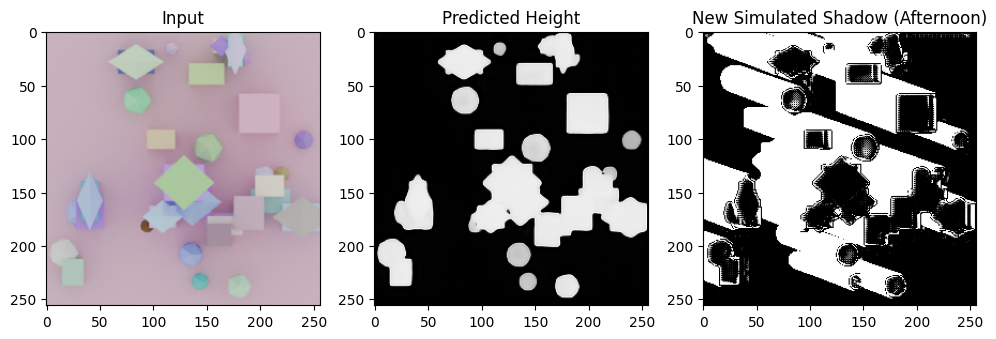

In [ ]:
test_image = "/kaggle/input/solarfold-v4/SolarFold_V4/RGB Flat/rgb_flat_0005.png"

# Let's ask for a shadow at a DIFFERENT time than the training data!
img, h, s = predict_shadow(test_image, sun_azimuth=70, sun_elevation=20)

# Plot
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1); plt.imshow(img.squeeze().permute(1,2,0).cpu()); plt.title("Input")
plt.subplot(1,3,2); plt.imshow(h.squeeze().cpu(), cmap='gray'); plt.title("Predicted Height")
plt.subplot(1,3,3); plt.imshow(s.squeeze().cpu(), cmap='gray'); plt.title("New Simulated Shadow (Afternoon)")
plt.show()

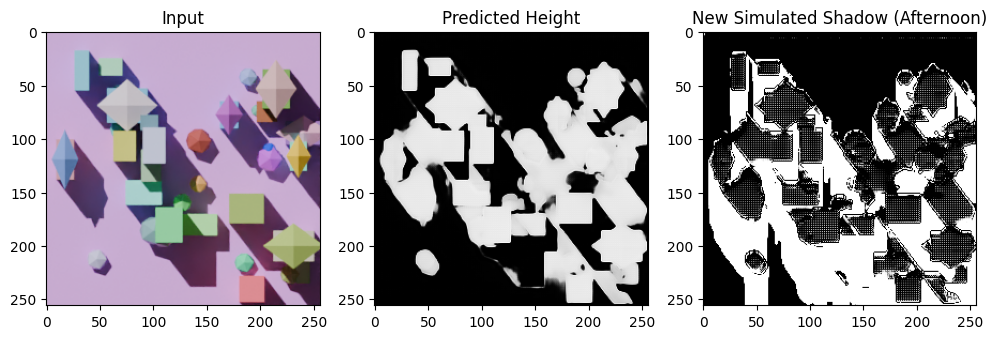

In [ ]:
test_image = "/kaggle/input/solarfold-dataset/SolarFold Dataset/RGB/rgb_0005.png" 

img, h, s = predict_shadow(test_image, sun_azimuth=340, sun_elevation=30)

# Plot
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1); plt.imshow(img.squeeze().permute(1,2,0).cpu()); plt.title("Input")
plt.subplot(1,3,2); plt.imshow(h.squeeze().cpu(), cmap='gray'); plt.title("Predicted Height")
plt.subplot(1,3,3); plt.imshow(s.squeeze().cpu(), cmap='gray'); plt.title("New Simulated Shadow (Afternoon)")
plt.show()

In [ ]:
def download_image_to_file(url, filename="temp_input.png"):
    response = requests.get(url)
    img = Image.open(io.BytesIO(response.content)).convert("RGB")
    img.save(filename)
    return filename

In [27]:
url = "https://i1.pickpik.com/photos/487/722/362/596877dfa00f6-preview.jpg"
test_image = download_image_to_file(url)

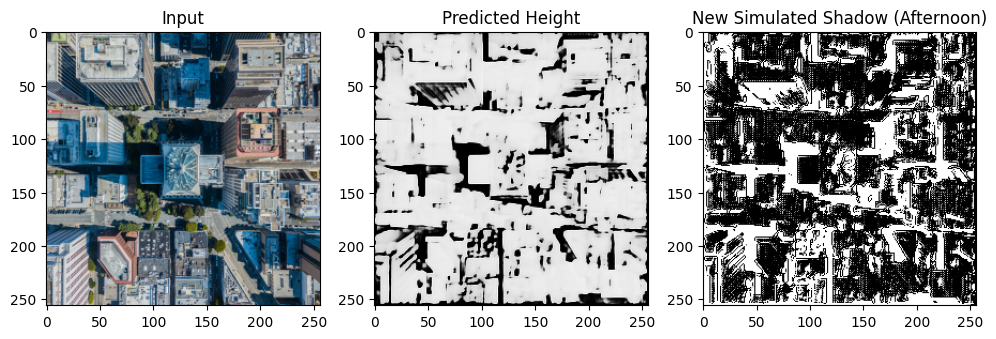

In [ ]:
img, h, s = predict_shadow(test_image, sun_azimuth=100, sun_elevation=30)

# Plot
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1); plt.imshow(img.squeeze().permute(1,2,0).cpu()); plt.title("Input")
plt.subplot(1,3,2); plt.imshow(h.squeeze().cpu(), cmap='gray'); plt.title("Predicted Height")
plt.subplot(1,3,3); plt.imshow(s.squeeze().cpu(), cmap='gray'); plt.title("New Simulated Shadow (Afternoon)")
plt.savefig("/kaggle/working/Real_100+30.png", dpi=300, bbox_inches='tight')
plt.show()

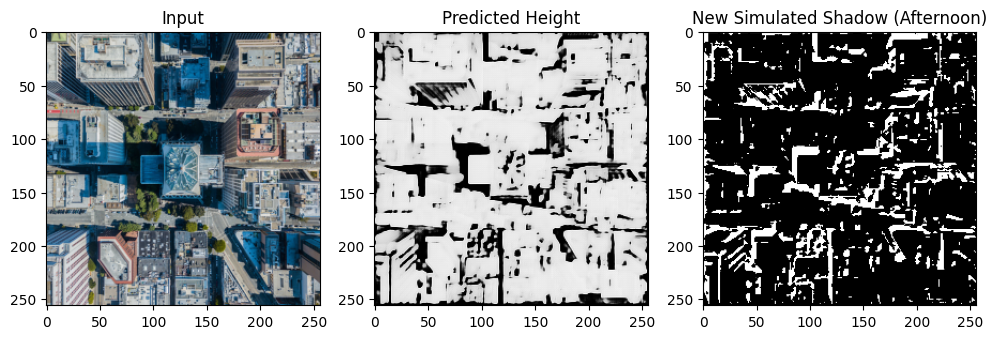

In [ ]:
img, h, s = predict_shadow(test_image, sun_azimuth=30, sun_elevation=70)

# Plot
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1); plt.imshow(img.squeeze().permute(1,2,0).cpu()); plt.title("Input")
plt.subplot(1,3,2); plt.imshow(h.squeeze().cpu(), cmap='gray'); plt.title("Predicted Height")
plt.subplot(1,3,3); plt.imshow(s.squeeze().cpu(), cmap='gray'); plt.title("New Simulated Shadow (Afternoon)")
plt.savefig("/kaggle/working/Real_30+70.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
def generate_timelapse(image_path, model_path='/kaggle/working/solarfold_v5.pth'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = SolarFold_Attention().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    physics = VectorizedRayCaster().to(device)    

    # Load Image
    img_pil = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((256, 256)), 
        transforms.ToTensor()
    ])
    img_tensor = transform(img_pil).unsqueeze(0).to(device)

    # Generate Sun Angles for a "Fake Day"
    # Sunrise (East/Low) -> Noon (South/High) -> Sunset (West/Low)
    
    # AZIMUTH: 90 (East) to 270 (West)
    azimuths = np.linspace(90, 270, 30) 
    
    # ELEVATION: 0 -> 70 (Noon) -> 0
    # Create a parabolic arc for height
    elevations = [70 * np.sin(np.pi * i / 29) for i in range(30)]
    
    frames = []
    
    print("Generating Frames...")
    for az, el in zip(azimuths, elevations):
        # Convert to Vector
        az_rad = np.radians(az)
        el_rad = np.radians(el)
        
        sun_x = np.cos(el_rad) * np.sin(az_rad)
        sun_y = np.cos(el_rad) * np.cos(az_rad)
        sun_z = np.sin(el_rad)
        
        sun_tensor = torch.tensor([sun_x, sun_y, sun_z], dtype=torch.float32).unsqueeze(0).to(device)
        
        # Inference
        with torch.no_grad():
            pred_height = model(img_tensor, sun_tensor, n_cycles=3)
            pred_shadow = physics(pred_height, sun_tensor)
            
        frames.append(pred_shadow.squeeze().cpu().numpy())

    return frames

In [ ]:
frames = generate_timelapse(test_image)

Generating Frames...


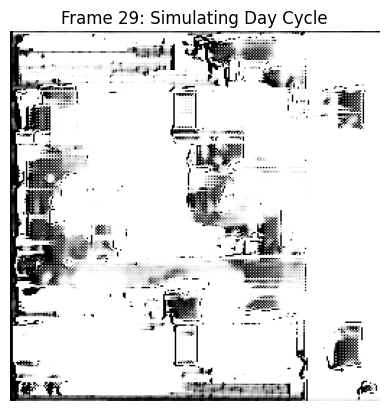

In [ ]:
# Display as animation
fig, ax = plt.subplots()
plt.axis('off')
im = ax.imshow(frames[0], cmap='gray', animated=True)

def update(i):
    im.set_array(frames[i])
    ax.set_title(f"Frame {i}: Simulating Day Cycle")
    return im,

ani = animation.FuncAnimation(fig, update, frames=len(frames), interval=100, blit=True)

ani.save('solarfold_timelapse.gif', writer='pillow')

plt.show()

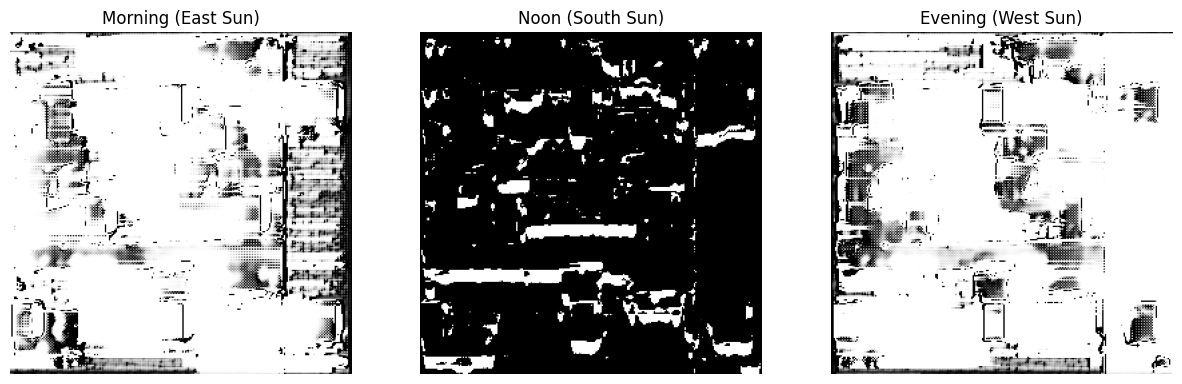

In [ ]:
# We pick 3 frames: Start (Morning), Middle (Noon), End (Evening)

idx_morning = 0
idx_noon = len(frames) // 2
idx_evening = len(frames) - 1

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(frames[idx_morning], cmap='gray')
plt.title("Morning (East Sun)")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(frames[idx_noon], cmap='gray')
plt.title("Noon (South Sun)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(frames[idx_evening], cmap='gray')
plt.title("Evening (West Sun)")
plt.axis('off')

plt.show()

In [34]:
url = "https://www.shutterstock.com/image-photo/roof-many-vents-awnings-white-600nw-2604714749.jpg"
test_image = download_image_to_file(url)

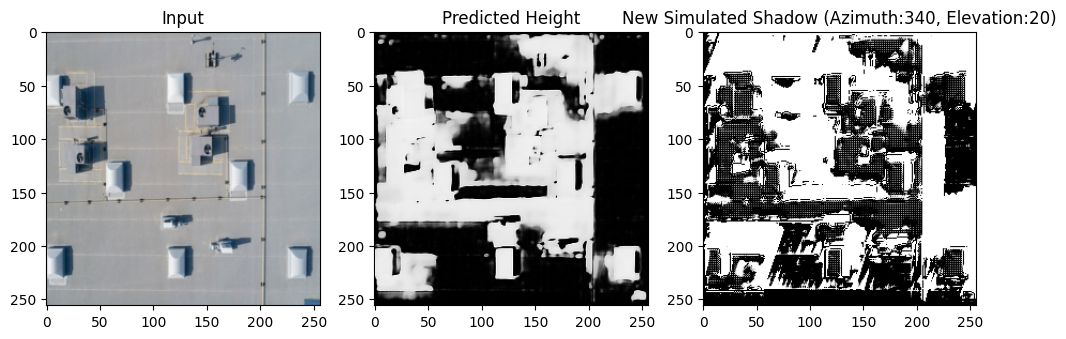

In [ ]:
img, h, s = predict_shadow(test_image, sun_azimuth=340, sun_elevation=20)

# Plot
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1); plt.imshow(img.squeeze().permute(1,2,0).cpu()); plt.title("Input")
plt.subplot(1,3,2); plt.imshow(h.squeeze().cpu(), cmap='gray'); plt.title("Predicted Height")
plt.subplot(1,3,3); plt.imshow(s.squeeze().cpu(), cmap='gray'); plt.title("New Simulated Shadow (Azimuth:340, Elevation:20)")
plt.savefig("/kaggle/working/Real_340+20.png", dpi=300, bbox_inches='tight')
plt.show()

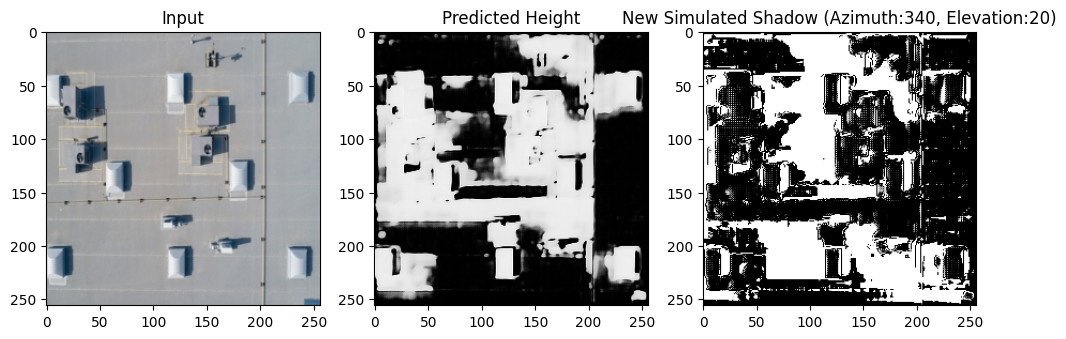

In [ ]:
img, h, s = predict_shadow(test_image, sun_azimuth=90, sun_elevation=30)

# Plot
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1); plt.imshow(img.squeeze().permute(1,2,0).cpu()); plt.title("Input")
plt.subplot(1,3,2); plt.imshow(h.squeeze().cpu(), cmap='gray'); plt.title("Predicted Height")
plt.subplot(1,3,3); plt.imshow(s.squeeze().cpu(), cmap='gray'); plt.title("New Simulated Shadow (Azimuth:340, Elevation:20)")
plt.savefig("/kaggle/working/Real_340+20.png", dpi=300, bbox_inches='tight')
plt.show()

**Inference**

In [ ]:
# 1. Setup Metrics
def calculate_rmse(pred, target):
    """Root Mean Square Error (lower is better)"""
    return torch.sqrt(torch.mean((pred - target) ** 2)).item()

def calculate_iou(pred_mask, target_mask, threshold=0.5):
    """Intersection over Union for Shadows (higher is better)"""
    # Binarize
    p = (pred_mask > threshold).float()
    t = (target_mask > threshold).float()
    
    intersection = (p * t).sum()
    union = p.sum() + t.sum() - intersection
    
    if union == 0: return 1.0 # Both empty
    return (intersection / union).item()

# 2. Evaluation Loop
def evaluate_model(dataset, model_path='/kaggle/input/solarfold-v5/pytorch/default/1/solarfold_v5.pth'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = SolarFold_Attention().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval() # Freeze weights
    physics = VectorizedRayCaster().to(device)
    model.eval()
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    total_rmse = 0.0
    total_iou = 0.0
    count = 0
    
    smoother = GaussianSmoothing(channels=1, kernel_size=3, sigma=0.5).to(device)
    physics = VectorizedRayCaster().to(device)

    print(f"Evaluating on {len(dataset)} images...")
    
    with torch.no_grad():
        for i, batch in enumerate(loader):
            img = batch['rgb'].to(device)
            target_h = batch['height'].to(device)
            target_s = batch['shadow'].to(device)
            sun_vec = batch['sun_vector'].to(device)
            
            pred_raw = model(img, sun_vec, n_cycles=3)
            pred_smooth = smoother(pred_raw) # Apply the blur fix
            
            # Physics Check (Optional: Check if the shadow matches GT shadow)
            pred_shadow = physics(pred_smooth, sun_vec)
            
            # Calculate Metrics
            # Note: We denormalize, max_height is 8.0 meters
            # RMSE in Meters
            rmse = calculate_rmse(pred_smooth * 8.0, target_h * 8.0) 
            iou = calculate_iou(pred_shadow, target_s)
            
            total_rmse += rmse
            total_iou += iou
            count += 1

            # Inside the evaluation loop...
            if count == 0:
                # diff = |Predicted - Target|
                diff_map = torch.abs(pred_smooth - target_h)
                
                plt.figure(figsize=(10, 3))
                plt.subplot(1, 3, 1); plt.imshow(pred_smooth.squeeze().cpu(), cmap='gray'); plt.title("Predicted")
                plt.subplot(1, 3, 2); plt.imshow(target_h.squeeze().cpu(), cmap='gray'); plt.title("Ground Truth")
                
                # Plot Error (Hotter = More Error)
                plt.subplot(1, 3, 3); plt.imshow(diff_map.squeeze().cpu(), cmap='hot', vmin=0, vmax=0.5); plt.title("Error Map")
                plt.colorbar()
                plt.savefig("error_analysis.png")
                plt.show()
            
    print("="*30)
    print(f"RESULTS:")
    print(f"Avg Height Error (RMSE): {total_rmse/count:.4f} meters")
    print(f"Avg Shadow Accuracy (IoU): {total_iou/count:.4f}")
    print("="*30)

In [60]:
evaluate_model(dataset)

Evaluating on 1060 images...
RESULTS:
Avg Height Error (RMSE): 2.5677 meters
Avg Shadow Accuracy (IoU): 0.4799


In [ ]:
def debug_evaluation(dataset, model_path='/kaggle/input/solarfold-v5/pytorch/default/1/solarfold_v5.pth', index=0):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = SolarFold_Attention().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    physics = VectorizedRayCaster().to(device)
    model.eval()
    
    data = dataset[index]
    
    # Add batch dimension
    img = data['rgb'].unsqueeze(0).to(device)
    target_h = data['height'].unsqueeze(0).to(device)
    target_s = data['shadow'].unsqueeze(0).to(device)
    sun_vec = data['sun_vector'].to(device)
    
    # Fix sun_vector shape if needed (Dataset returns 1D tensor, we need Batch dim)
    if len(sun_vec.shape) == 1:
        sun_vec = sun_vec.unsqueeze(0).to(device)

    # Setup Components
    smoother = GaussianSmoothing(channels=1, kernel_size=3, sigma=0.5).to(device)
    physics = VectorizedRayCaster().to(device)
    
    with torch.no_grad():
        # Inference
        pred_raw = model(img, sun_vec, n_cycles=3)
        pred_h = smoother(pred_raw)
        pred_s = physics(pred_h, sun_vec)
        
        # Calculate Errors
        # 1. Height Diff (Absolute error)
        diff_h = torch.abs(pred_h - target_h)
        mae = diff_h.mean().item() * 8.0 # Mean Absolute Error in meters
        
        # 2. Shadow IoU
        inter = ((pred_s > 0.5) & (target_s > 0.5)).float().sum()
        union = ((pred_s > 0.5) | (target_s > 0.5)).float().sum()
        iou = (inter / (union + 1e-6)).item()

    fig, ax = plt.subplots(2, 3, figsize=(15, 10))
    
    # ROW 1: Height
    ax[0,0].imshow(target_h.squeeze().cpu(), cmap='gray', vmin=0, vmax=1)
    ax[0,0].set_title("Ground Truth Height")
    
    ax[0,1].imshow(pred_h.squeeze().cpu(), cmap='gray', vmin=0, vmax=1)
    ax[0,1].set_title(f"Pred Height (Max: {pred_h.max():.2f})")
    
    # ERROR MAP (Hotter = More Error)
    im = ax[0,2].imshow(diff_h.squeeze().cpu(), cmap='hot', vmin=0, vmax=0.5)
    ax[0,2].set_title(f"Height Error (Avg: {mae:.2f}m)")
    plt.colorbar(im, ax=ax[0,2])
    
    # ROW 2: Shadow
    ax[1,0].imshow(target_s.squeeze().cpu(), cmap='gray')
    ax[1,0].set_title("Ground Truth Shadow")
    
    ax[1,1].imshow(pred_s.squeeze().cpu(), cmap='gray')
    ax[1,1].set_title("Pred Shadow (Physics)")
    
    # SHADOW OVERLAP (Green = Correct, Red = Wrong)
    # Create an RGB image for overlap
    # Red channel = Target
    # Green channel = Pred
    vis_shadow = torch.zeros(256, 256, 3)
    vis_shadow[:,:,0] = target_s.squeeze().cpu() # GT is Red
    vis_shadow[:,:,1] = pred_s.squeeze().cpu()   # Pred is Green
    # Results: Yellow is Match. Red is Missed Shadow. Green is Extra Shadow.
    
    ax[1,2].imshow(vis_shadow)
    ax[1,2].set_title(f"Shadow Overlay (IoU: {iou:.2f})\nYellow=Match, Red=GT Only, Green=Pred Only")
    
    plt.tight_layout()
    plt.savefig("debug_report.png")
    plt.show()

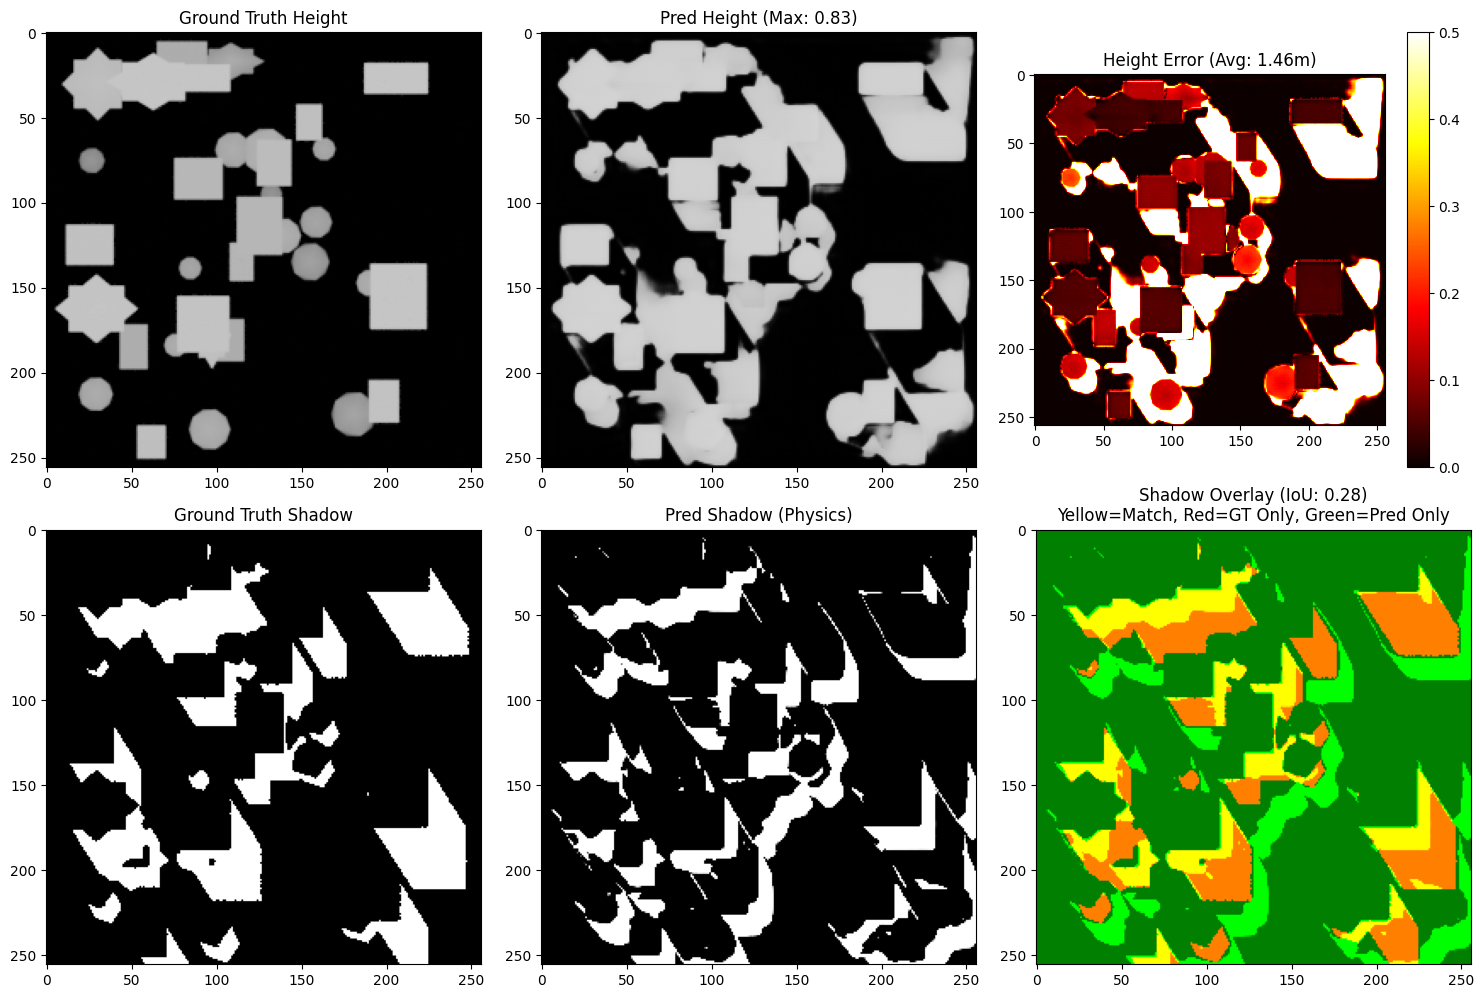

In [62]:
debug_evaluation(dataset, index=0)